In [1]:
using CSV
using DataFrames
using Distributions
using KernelDensity
using Plots
using StatsPlots

using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
#using Distributed
# using DiffEqGPU
using ODEInterfaceDiffEq
using JLD
using HDF5
using Distances
using Random
using InformationMeasures
using Distances
using HypothesisTests


## Load Posteriors

In [2]:
POS1 = Matrix(DataFrame!(CSV.File("ToggleSwitchImplementationModel3\\PosteriorsCSV\\draws_ALL_Model3.csv")));
POS2 = Matrix(DataFrame!(CSV.File("E:\\UNI\\D_Drive\\RSTAN\\Model3_WIP_Samples.csv")));

In [3]:
names = ["p1","p2","p3","p4","p5","p6","p7","p8","p9","p10","p11","p12","p13","p14"];

## Hypothesis tests

In [4]:
tests = Dict()
for i in 1:14
    tests[names[i]] = ApproximateTwoSampleKSTest(POS1[:,i], POS2[:,i])
end

#### Check P Values

In [5]:
nhr = [];
for i in 1:14
    if pvalue(tests[names[i]])<0.05
        nhr = vcat(nhr, i)
    end
end
nhr

5-element Array{Any,1}:
  3
  8
  9
 10
 13

#### Show rejected p values

In [6]:
[pvalue(tests[names[i]]) for i in nhr]

5-element Array{Float64,1}:
 9.607391388473412e-6
 0.03810690663913187
 0.00807200896595424
 0.0014931716161319837
 0.0009750928901498453

## Entropy

In [7]:
[get_entropy(POS1[:,i]) for i in nhr]

5-element Array{Float64,1}:
 5.719521270895365
 5.583094565396673
 5.691575844709441
 5.593231954506248
 5.638918609136067

In [8]:
[get_entropy(POS2[:,i]) for i in nhr]

5-element Array{Float64,1}:
 5.664266952408199
 5.509945964562002
 5.6314974574099965
 5.7680592533629
 5.735225379409848

## Distances

Take samples from the logNormal prior

In [9]:
Random.seed!(789);
priorOld = truncated(Normal(0,1), -2, 2)
samplesRAW = rand(priorOld,8000,14);
samplesOLD = zeros(size(samplesRAW));
size(samplesOLD)
for i in 1:size(samplesOLD)[1]
    samplesOLD[i,1] = exp(((samplesRAW[i,1])*(1.15129254649702))+(-3.2188758248682));
    
    samplesOLD[i,2] = exp(((samplesRAW[i,2])*(1.15129254649702))+(-2.30258509299405));
    samplesOLD[i,3] = exp(((samplesRAW[i,3])*(1.15129254649702))+(-3.50655789731998));
    samplesOLD[i,4] = exp(((samplesRAW[i,4])*(1.15129254649702))+(2.30258509299405));
    samplesOLD[i,5] = exp(((samplesRAW[i,5])*(1.15129254649702))+(3.40119738166216));
    samplesOLD[i,6] = exp(((samplesRAW[i,6])*(1.15129254649702))+(2.30258509299405));
    samplesOLD[i,7] = (((samplesRAW[i,7])*(1.25))+(2.5));
    samplesOLD[i,8] = (((samplesRAW[i,8])*(1.25))+(2.5));
    samplesOLD[i,9] = exp((((samplesRAW[i,9]))*(1.15129254649702))-2.30258509299405);
    samplesOLD[i,10] = exp(((samplesRAW[i,10])*(1.15129254649702))+(2.22044604925031e-16));
    samplesOLD[i,11] = exp(((samplesRAW[i,11])*(1.15129254649702))+3.40119738166216);
    samplesOLD[i,12] = exp(((samplesRAW[i,12])*(1.15129254649702))-2.30258509299405);
    samplesOLD[i,13] = ((samplesRAW[i,13])*(1.25))+2.5;
    samplesOLD[i,14] = ((samplesRAW[i,14])*(1.25))+2.5;
end

Distance between posteriors

In [10]:
for i in nhr
    x1 = kde(POS1[:,i], boundary=(minimum([kde(POS1[:,i]).x[1], kde(POS2[:,i]).x[1]]), maximum([kde(POS1[:,i]).x[end], kde(POS2[:,i]).x[end]]))).density;
    x2 = kde(POS2[:,i], boundary=(minimum([kde(POS1[:,i]).x[1], kde(POS2[:,i]).x[1]]), maximum([kde(POS1[:,i]).x[end], kde(POS2[:,i]).x[end]]))).density;
    println(bhattacharyya(x1,x2))
end

0.0013917591633257288
0.0007292329139986136
0.0006737493440176889
0.0009382093809166811
0.0008351262434664566


Distance between posterirors and one of the priors (log normal)

In [11]:
# High informative 
for i in nhr
    x1 = kde(POS1[:,i], boundary=(kde(samplesOLD[:,i]).x[1], kde(samplesOLD[:,i]).x[end])).density;
    x2 = kde(samplesOLD[:,i], boundary=(kde(samplesOLD[:,i]).x[1], kde(samplesOLD[:,i]).x[end])).density;
    println(bhattacharyya(x1,x2))
end

1.7422089310311422
1.4170271974573203
1.4092151699953936
2.0256928773226868
2.1181707888777073


In [12]:
# Low informative
for i in nhr
    x1 = kde(POS2[:,i], boundary=(kde(samplesOLD[:,i]).x[1], kde(samplesOLD[:,i]).x[end])).density;
    x2 = kde(samplesOLD[:,i], boundary=(kde(samplesOLD[:,i]).x[1], kde(samplesOLD[:,i]).x[end])).density;
    println(bhattacharyya(x1,x2))
end

1.7332924504140488
1.4237005112066161
1.4176815780423946
2.0210685897455782
2.1178879595165787


## Kernel Density Plots

In [13]:
length(nhr)

5

In [14]:
mkdir("KernelDensity")

Base.IOError: IOError: mkdir: file already exists (EEXIST)

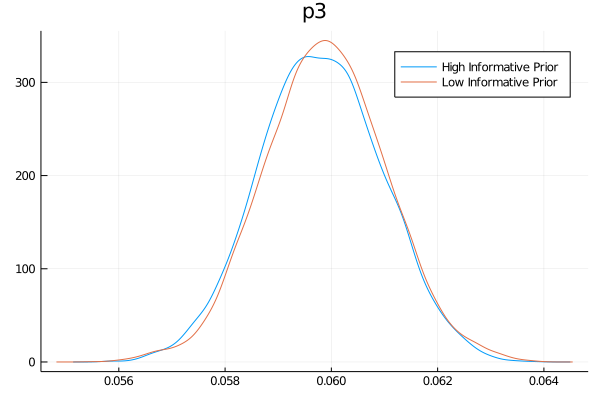

In [15]:
i=nhr[1]
plot(kde(POS1[:,i]), label = "High Informative Prior", title = names[i])
plot!(kde(POS2[:,i]), label = "Low Informative Prior")

# savefig("KernelDensity\\myplot.svg")

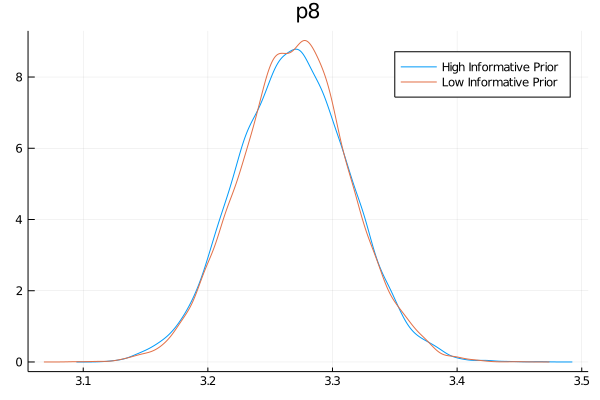

In [16]:
i=nhr[2]
plot(kde(POS1[:,i]), label = "High Informative Prior", title = names[i])
plot!(kde(POS2[:,i]), label = "Low Informative Prior")

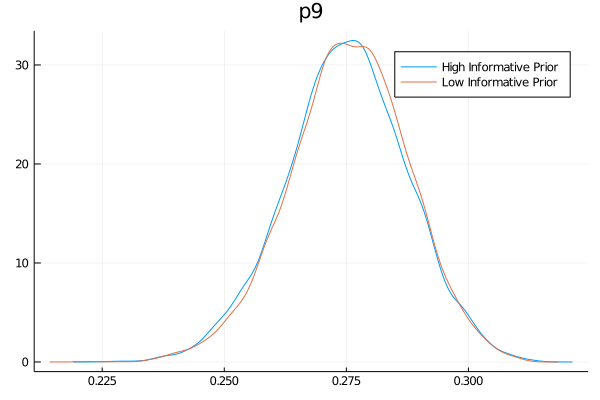

In [17]:
i=nhr[3]
plot(kde(POS1[:,i]), label = "High Informative Prior", title = names[i])
plot!(kde(POS2[:,i]), label = "Low Informative Prior")

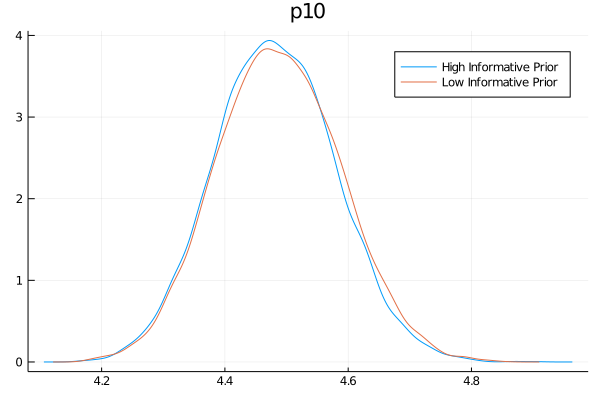

In [18]:
i=nhr[4]
plot(kde(POS1[:,i]), label = "High Informative Prior", title = names[i])
plot!(kde(POS2[:,i]), label = "Low Informative Prior")

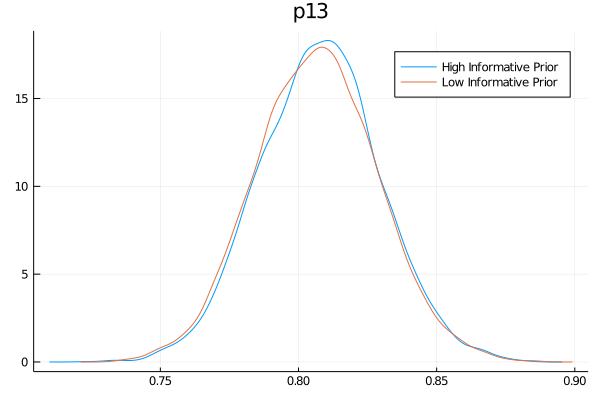

In [19]:
i=nhr[5]
plot(kde(POS1[:,i]), label = "High Informative Prior", title = names[i])
plot!(kde(POS2[:,i]), label = "Low Informative Prior")

#### All parameters together

In [20]:
using LaTeXStrings

Posterior 0 indicates the posterior coming from the informative prior  <br>
Posterior 1 indicates the posterior coming from the weakly infomative prior

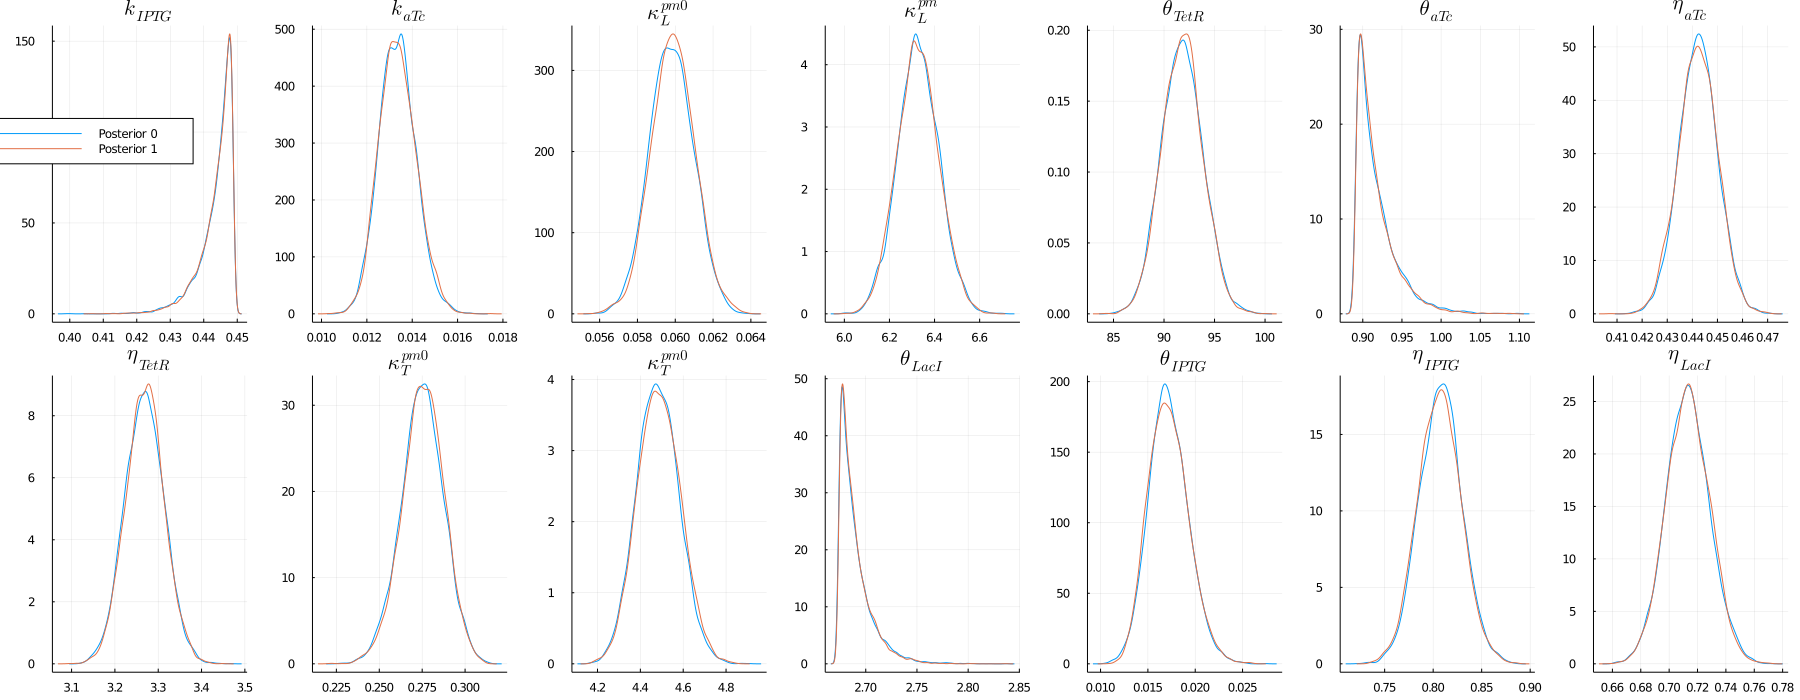

In [25]:
p1 = plot(kde(POS1[:,1]), label = "Posterior 0", title = L"$k_{IPTG}$")
p1 = plot!(kde(POS2[:,1]), label = "Posterior 1")

p2 = plot(kde(POS1[:,2]), label="", title = L"$k_{aTc}$")
p2 = plot!(kde(POS2[:,2]), label="")

p3 = plot(kde(POS1[:,3]), label="", title = L"$\kappa_{L}^{pm0}$")
p3 = plot!(kde(POS2[:,3]), label="")

p4 = plot(kde(POS1[:,4]), label="", title = L"$\kappa_{L}^{pm}$")
p4 = plot!(kde(POS2[:,4]), label="")

p5 = plot(kde(POS1[:,5]), label="", title = L"$\theta_{TetR}$")
p5 = plot!(kde(POS2[:,5]), label="")

p6 = plot(kde(POS1[:,6]), label="", title = L"$\theta_{aTc}$")
p6 = plot!(kde(POS2[:,6]), label="")

p7 = plot(kde(POS1[:,7]), label="", title = L"$\eta_{aTc}$")
p7 = plot!(kde(POS2[:,7]), label="")

p8 = plot(kde(POS1[:,8]), label="", title = L"$\eta_{TetR}$")
p8 = plot!(kde(POS2[:,8]), label="")

p9 = plot(kde(POS1[:,9]), label="", title = L"$\kappa_{T}^{pm0}$")
p9 = plot!(kde(POS2[:,9]), label="")

p10 = plot(kde(POS1[:,10]), label="", title = L"$\kappa_{T}^{pm0}$")
p10 = plot!(kde(POS2[:,10]), label="")

p11 = plot(kde(POS1[:,11]), label="", title = L"$\theta_{LacI}$")
p11 = plot!(kde(POS2[:,11]), label="")

p12 = plot(kde(POS1[:,12]), label="", title = L"$\theta_{IPTG}$")
p12 = plot!(kde(POS2[:,12]), label="")

p13 = plot(kde(POS1[:,13]), label="", title = L"$\eta_{IPTG}$")
p13 = plot!(kde(POS2[:,13]), label="")

p14 = plot(kde(POS1[:,14]), label="", title = L"$\eta_{LacI}$")
p14 = plot!(kde(POS2[:,14]), label="")

plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14, layout =(2,7), size = (1800, 700))

# savefig("KernelDensity\\AllKDE.svg")
# savefig("KernelDensity\\AllKDE.png")

## Comparison mean, standard deviation and covariances

Means

In [64]:
[mean(POS1[:,i]) for i in nhr]

5-element Array{Float64,1}:
 0.05980077885346132
 3.2682970440611574
 0.274994347269609
 4.481803576253977
 0.8077291146380488

In [65]:
[mean(POS2[:,i]) for i in nhr]

5-element Array{Float64,1}:
 0.05988735894165678
 3.2694470845259533
 0.27550148720821543
 4.488054793523881
 0.8065073383994221

Standard Deviations

In [66]:
[std(POS1[:,i]) for i in nhr]

5-element Array{Float64,1}:
 0.001151721505975198
 0.04509067241110476
 0.012409963412178773
 0.09772386874169682
 0.021794978930052694

In [67]:
[std(POS2[:,i]) for i in nhr]

5-element Array{Float64,1}:
 0.0011571851382965045
 0.0441374073189055
 0.012185548217590875
 0.09996144005947094
 0.022086881429823485

Covariances

In [68]:
cov(POS1)

14×14 Array{Float64,2}:
  2.53262e-5   1.24044e-7  -1.05905e-7   …  -1.08998e-5    2.30129e-6
  1.24044e-7   6.46866e-7   3.28886e-9      -9.49699e-6    3.78792e-7
 -1.05905e-7   3.28886e-9   1.32646e-6       1.37075e-6    3.94077e-6
  3.34117e-6   7.52079e-6  -9.82037e-6       1.57899e-5    0.000350039
 -0.00022305   7.8983e-6   -0.000242204     -0.00244937   -0.0183849
 -5.67972e-7   1.36466e-6  -1.08615e-6   …   4.6795e-6    -4.84394e-6
 -6.43601e-8  -4.55124e-6   1.13586e-6       7.54272e-5    3.2994e-5
 -3.50015e-6   7.97045e-6   8.5725e-6       -8.11956e-5   -0.000313566
  3.98788e-7   3.82288e-7   3.93717e-6      -2.79251e-5    0.000166458
 -4.93766e-6   1.47407e-5   2.95231e-5      -0.000104552  -0.000717692
 -1.15705e-7  -5.43784e-8   1.87331e-7   …   1.14957e-5    8.52003e-6
 -9.46544e-7  -4.53549e-7   4.66244e-7       3.39105e-5   -1.18142e-5
 -1.08998e-5  -9.49699e-6   1.37075e-6       0.000475021  -5.82435e-5
  2.30129e-6   3.78792e-7   3.94077e-6      -5.82435e-5    0.000

In [77]:
cov(POS2)

14×14 Array{Float64,2}:
  2.38628e-5   1.05953e-7   1.70251e-8   …  -8.19861e-6    7.82573e-7
  1.05953e-7   6.72086e-7   1.39807e-8      -1.06115e-5    3.78158e-7
  1.70251e-8   1.39807e-8   1.33908e-6       2.27976e-7    3.65562e-6
  1.4436e-6    8.4148e-6   -1.34112e-5       2.76279e-5    0.000272209
 -8.90128e-5   4.11248e-5  -0.000143328     -0.00314108   -0.0170565
 -7.39247e-7   1.61841e-6  -2.81126e-7   …   4.06452e-6    3.42515e-6
 -2.25772e-7  -4.85146e-6   1.11284e-6       8.44572e-5    3.26039e-5
  1.74372e-6   8.33884e-6   1.03711e-5      -0.000116129  -0.000288989
 -3.76843e-7   3.94128e-7   3.43783e-6      -2.96142e-5    0.00016148
 -5.81037e-6   1.66551e-5   2.93876e-5      -0.000168692  -0.000763466
  4.19347e-7  -9.54348e-8  -8.64017e-8   …   6.22351e-6    5.38613e-6
 -7.40282e-7  -5.22382e-7   3.60037e-7       3.42357e-5   -1.26661e-5
 -8.19861e-6  -1.06115e-5   2.27976e-7       0.00048783   -5.84498e-5
  7.82573e-7   3.78158e-7   3.65562e-6      -5.84498e-5    0.000

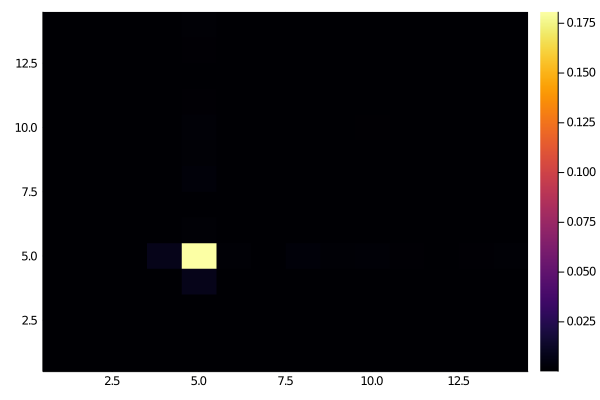

In [144]:
heatmap((abs.(cov(POS1)-cov(POS2))))

Correlation

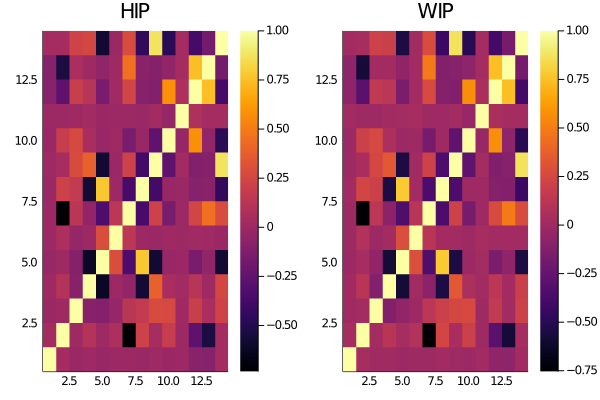

In [100]:
p1 = heatmap(cor(POS1), title = "HIP")
p2 = heatmap(cor(POS2), title = "WIP")
plot(p1,p2)